Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
NUM_KNAPSACKS = 3
NUM_ITEMS = 10
NUM_DIMENSIONS = 2

In [3]:
VALUES = np.random.randint(0, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [4]:
def fitness(solution):
    """Calculate the fitness of a given solution."""
    return np.sum(VALUES[solution >= 0])

def is_feasible(solution):
    """Check if a given solution is feasible."""
    # Check constraints for each knapsack
    for k in range(NUM_KNAPSACKS):
        if np.any(np.sum(WEIGHTS[solution == k], axis=0) > CONSTRAINTS[k]):
            return False
    return True

def get_solution():
    """Generate a random feasible solution."""
    # Start with a random assignment
    solution = np.random.choice(np.arange(NUM_KNAPSACKS), size=NUM_ITEMS)
    # Remove items until the solution is feasible
    while not is_feasible(solution):
        i = np.random.randint(0, NUM_ITEMS)
        solution[i] = -1
    return solution

In [5]:
class ExperimentResult:
    """Class to store and analyze the results of an experiment."""
    def __init__(self, name):
        self.name = name
        self.fitness_history = []
        self.best_solution = None
        self.best_fitness = -1
        self.restarts = []
    
    def add_fitness(self, fitness, solution):
        """"Add a new fitness value and update the best solution if necessary."""
        self.fitness_history.append(fitness)
        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_solution = solution.copy()
    
    def plot_fitness(self):
        """Plot the fitness history with restarts and optimal fitness."""
        _, ax = plt.subplots()
        # Plot cumulative max fitness
        ax.plot(self.fitness_history, label="Cumulative max fitness")
        # If there are restarts, plot vertical lines
        if len(self.restarts) > 0:
            for r in self.restarts:
                ax.axvline(r, color='red', linestyle='--', alpha=0.5, label="Restart" if r == self.restarts[0] else "")
        # Plot optimal fitness line, assuming optimal is sum of all VALUES
        ax.axhline(np.sum(VALUES), color='green', linestyle='--', alpha=0.5, label="Optimal")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Fitness")
        ax.set_title(self.name)
        ax.set_xlim(0, len(self.fitness_history))
        ax.set_ylim(0, np.sum(VALUES) * 1.1)
        ax.legend(loc='lower right')
        plt.show()
        return ax
    
    def join(self, other):
        """Join another ExperimentResult into this one."""
        # Store the restart point
        self.restarts.append(len(self.fitness_history))
        # Extend fitness history
        self.fitness_history.extend(other.fitness_history)
        # Update best solution if the other is better
        if other.best_fitness > self.best_fitness:
            self.best_fitness = other.best_fitness
            self.best_solution = other.best_solution.copy()
    
    def __str__(self):
        """String representation of the experiment results."""
        header = f"Experiment: {self.name}\n"
        best = f"Best Fitness: {self.best_fitness}\n"
        # Detailed best solution
        for k in range(NUM_KNAPSACKS):
            best += f" Knapsack {k}: items {np.where(self.best_solution == k)[0].tolist()}\n"
        best += f" Unassigned items: {np.where(self.best_solution == -1)[0].tolist()}\n"
        return header + best

In [6]:
def tweak(solution):
    """Generate a neighboring solution by tweaking the current solution."""
    # Choose a random item
    i = np.random.randint(0, NUM_ITEMS)
    feasible_choices = np.arange(-1, NUM_KNAPSACKS)
    # Choose a new backpack for the item OR unassign it
    new_value = np.random.choice(feasible_choices)
    while new_value == solution[i]:
        new_value = np.random.choice(feasible_choices)
    new_solution = solution.copy()
    old_value = new_solution[i]
    new_solution[i] = new_value
    # If we unassigned an item, assign the backpack to a random unassigned item (if any)
    if new_value == -1:
        unassigned_items = np.arange(NUM_ITEMS)[solution == -1]
        if len(unassigned_items) >= 1:
            j = np.random.choice(unassigned_items)
            new_solution[j] = old_value
    return new_solution

In [7]:
def hc_solver(solution, max_iter=10000):
    """Hill Climbing solver for the knapsack problem."""
    best_solution = solution.copy()
    best_fitness = fitness(solution) if is_feasible(solution) else 0
    results = ExperimentResult("Hill Climbing")
    results.add_fitness(best_fitness, best_solution)
    for _ in tqdm(range(max_iter)):
        new_solution = tweak(best_solution)
        if is_feasible(new_solution):
            new_fitness = fitness(new_solution)
            if new_fitness >= best_fitness:
                best_solution = new_solution
                best_fitness = new_fitness
        results.add_fitness(best_fitness, best_solution)
    return results

In [8]:
def hc_steepest_ascent_solver(solution, max_iter=1000):
    best_solution = solution.copy()
    best_fitness = fitness(solution) if is_feasible(solution) else 0
    results = ExperimentResult("Steepest Ascent Hill Climbing")
    results.add_fitness(best_fitness, best_solution)
    for _ in tqdm(range(max_iter)):
        neighbors = [tweak(best_solution) for _ in range(10)]
        feasible_neighbors = [s for s in neighbors if is_feasible(s)]
        if not feasible_neighbors:
            results.add_fitness(best_fitness, best_solution)
            continue
        new_solution = max(feasible_neighbors, key=fitness)
        new_fitness = fitness(new_solution)
        if new_fitness >= best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
        results.add_fitness(best_fitness, best_solution)
    return results

In [9]:
def sa_solver(solution, max_iter=10000, initial_temp=100, cooling_rate=0.99, restarted=False):
    current_solution = solution.copy()
    current_fitness = fitness(solution) if is_feasible(solution) else 0
    results = ExperimentResult("Simulated Annealing")
    results.add_fitness(current_fitness, current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness
    temp = initial_temp
    for _ in tqdm(range(max_iter)):
        new_solution = tweak(current_solution)
        if is_feasible(new_solution):
            new_fitness = fitness(new_solution)
            if new_fitness >= current_fitness:
                current_solution = new_solution
                current_fitness = new_fitness
                if new_fitness >= best_fitness:
                    best_solution = new_solution
                    best_fitness = new_fitness
                if restarted and new_fitness >= best_fitness:
                    temp = initial_temp
            else:
                acceptance_prob = np.exp((new_fitness - current_fitness) / temp)
                if np.random.rand() < acceptance_prob:
                    current_solution = new_solution
                    current_fitness = new_fitness
        temp *= cooling_rate
        results.add_fitness(best_fitness, best_solution)
    return results

## Test problem 1

In [10]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [11]:
solution = np.ones(NUM_ITEMS, dtype=int) * -1
solution = get_solution()

100%|██████████| 500/500 [00:00<00:00, 5886.45it/s]

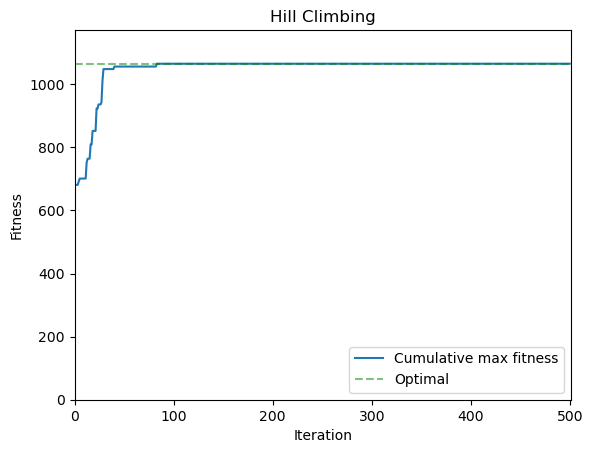

Experiment: Hill Climbing
Best Fitness: 1065
 Knapsack 0: items [2, 3, 5, 6, 7, 8, 9, 10, 17, 18]
 Knapsack 1: items [0, 1, 4, 12, 13, 14]
 Knapsack 2: items [11, 15, 16, 19]
 Unassigned items: []



In [12]:
results = hc_solver(solution, max_iter=500)
results.plot_fitness()
print(results)

100%|██████████| 50/50 [00:00<00:00, 838.06it/s]


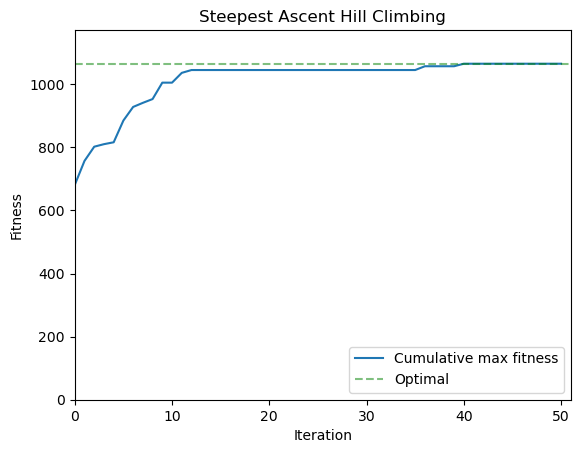

Experiment: Steepest Ascent Hill Climbing
Best Fitness: 1065
 Knapsack 0: items [2, 5, 8, 10, 11, 13, 16, 18, 19]
 Knapsack 1: items [1, 3, 6, 9, 14, 15]
 Knapsack 2: items [0, 4, 7, 12, 17]
 Unassigned items: []



In [13]:
results = hc_steepest_ascent_solver(solution, max_iter=50)
results.plot_fitness()
print(results)

100%|██████████| 500/500 [00:00<00:00, 7901.47it/s]


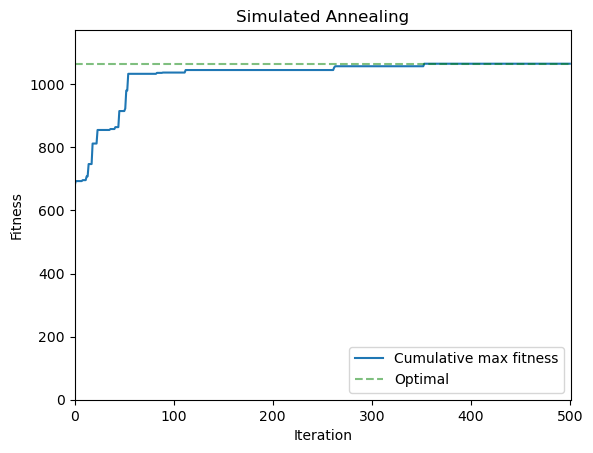

Experiment: Simulated Annealing
Best Fitness: 1065
 Knapsack 0: items [4, 6, 7, 8, 9, 11, 14, 15, 17, 19]
 Knapsack 1: items [0, 2, 10, 12, 13, 16]
 Knapsack 2: items [1, 3, 5, 18]
 Unassigned items: []



In [14]:
results = sa_solver(solution, max_iter=500)
results.plot_fitness()
print(results)

## Test problem 2

In [15]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [16]:
solution = np.ones(NUM_ITEMS, dtype=int) * -1
solution = get_solution()

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:08<00:00, 5557.21it/s]


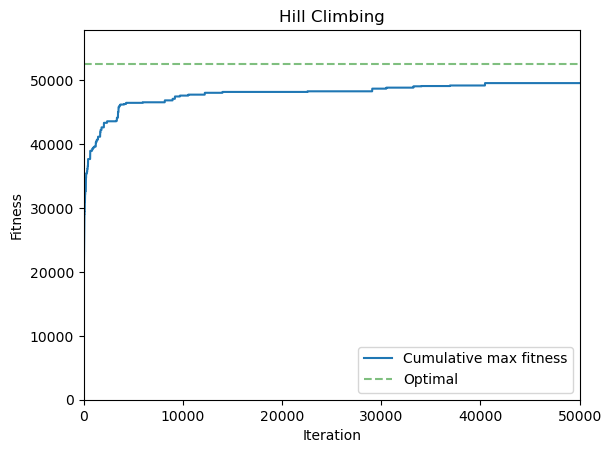

Experiment: Hill Climbing
Best Fitness: 49585
 Knapsack 0: items [19, 33, 41, 51, 61, 68, 87]
 Knapsack 1: items [21, 31, 36, 37, 45, 56, 58, 72]
 Knapsack 2: items [7, 25, 42, 54, 69, 71]
 Knapsack 3: items [5, 11, 12, 14, 20, 24, 27, 62, 64, 74, 97]
 Knapsack 4: items [16, 34, 50, 52, 59, 63, 66, 84, 85, 93]
 Knapsack 5: items [1, 2, 10, 70, 75, 78, 81, 95]
 Knapsack 6: items [9, 15, 22, 28, 38, 39, 60, 83, 92]
 Knapsack 7: items [40, 47, 48, 49, 91, 98]
 Knapsack 8: items [4, 6, 8, 30, 43, 88, 89, 94]
 Knapsack 9: items [3, 13, 17, 18, 23, 29, 46, 53, 65, 79, 80]
 Unassigned items: [0, 26, 32, 35, 44, 55, 57, 67, 73, 76, 77, 82, 86, 90, 96, 99]



In [17]:
results = hc_solver(solution, max_iter=50000)
results.plot_fitness()
print(results)

 71%|███████   | 70517/100000 [00:10<00:04, 6323.37it/s]/tmp/ipykernel_13992/39911299.py:22: RuntimeWarning: overflow encountered in divide
  acceptance_prob = np.exp((new_fitness - current_fitness) / temp)
100%|██████████| 100000/100000 [00:15<00:00, 6490.97it/s]


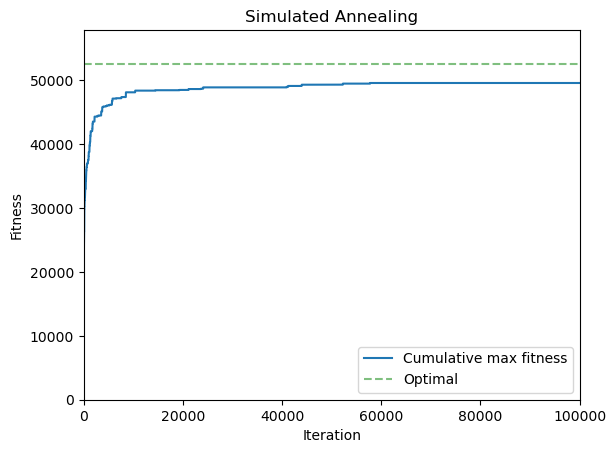

Experiment: Simulated Annealing
Best Fitness: 49602
 Knapsack 0: items [12, 34, 41, 85, 90, 91]
 Knapsack 1: items [21, 29, 43, 49, 50, 53, 66]
 Knapsack 2: items [7, 15, 61, 69, 72, 77, 93]
 Knapsack 3: items [22, 24, 27, 28, 37, 52, 62, 84, 94, 97, 99]
 Knapsack 4: items [5, 9, 10, 19, 33, 36, 42, 48, 58, 63, 81]
 Knapsack 5: items [2, 18, 26, 39, 46, 60, 70, 80, 98]
 Knapsack 6: items [3, 11, 38, 51, 54, 74, 78, 87, 92]
 Knapsack 7: items [1, 8, 31, 47, 56, 59, 75]
 Knapsack 8: items [16, 20, 30, 68, 86, 88, 89]
 Knapsack 9: items [13, 14, 17, 23, 25, 45, 65, 79, 83, 95]
 Unassigned items: [0, 4, 6, 32, 35, 40, 44, 55, 57, 64, 67, 71, 73, 76, 82, 96]



In [18]:
results = sa_solver(solution, max_iter=100000)
results.plot_fitness()
print(results)

100%|██████████| 100000/100000 [00:15<00:00, 6547.19it/s]


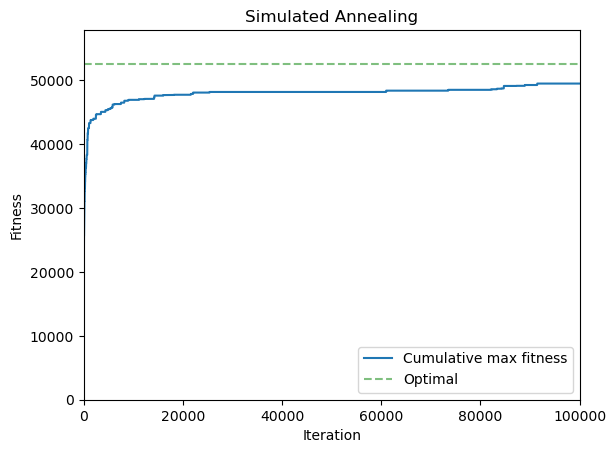

Experiment: Simulated Annealing
Best Fitness: 49513
 Knapsack 0: items [28, 33, 37, 45, 51, 66, 72]
 Knapsack 1: items [19, 21, 34, 36, 42, 43, 49, 50]
 Knapsack 2: items [2, 7, 12, 14, 22, 25, 27]
 Knapsack 3: items [10, 11, 13, 41, 62, 74, 84, 89, 94, 99]
 Knapsack 4: items [5, 15, 23, 24, 46, 53, 75, 87, 90, 93, 97]
 Knapsack 5: items [18, 29, 40, 54, 59, 60, 70, 78, 83]
 Knapsack 6: items [1, 3, 8, 63, 79, 92]
 Knapsack 7: items [6, 39, 47, 56, 58, 69]
 Knapsack 8: items [4, 30, 38, 64, 88, 91, 98]
 Knapsack 9: items [17, 20, 31, 48, 52, 61, 65, 77, 80, 81, 85, 95]
 Unassigned items: [0, 9, 16, 26, 32, 35, 44, 55, 57, 67, 68, 71, 73, 76, 82, 86, 96]



In [19]:
results = sa_solver(solution, max_iter=100000, restarted=True)
results.plot_fitness()
print(results)

100%|██████████| 4/4 [00:13<00:00,  3.47s/it]


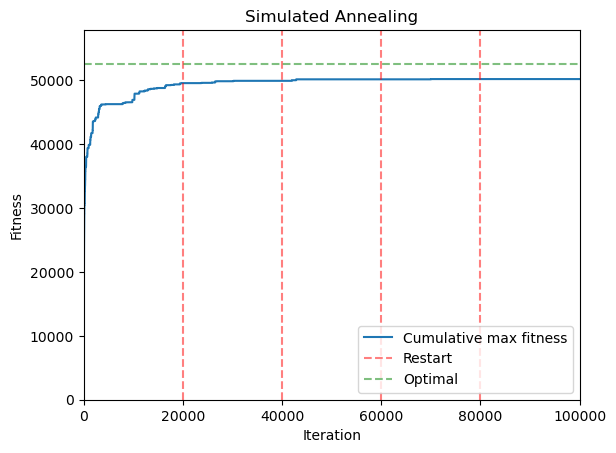

Experiment: Simulated Annealing
Best Fitness: 50216
 Knapsack 0: items [14, 50, 60, 61, 64, 72, 98]
 Knapsack 1: items [12, 21, 23, 25, 34, 47, 48, 84, 95]
 Knapsack 2: items [3, 7, 27, 40, 73, 85, 93]
 Knapsack 3: items [11, 15, 24, 26, 33, 41, 52, 62, 69, 97, 99]
 Knapsack 4: items [5, 10, 13, 17, 36, 42, 45, 58, 59, 70, 74]
 Knapsack 5: items [4, 16, 18, 28, 29, 66, 75, 88]
 Knapsack 6: items [2, 8, 9, 43, 46, 53, 54, 87, 92]
 Knapsack 7: items [1, 6, 49, 63, 89]
 Knapsack 8: items [19, 20, 38, 39, 51, 56, 78, 91, 94]
 Knapsack 9: items [22, 30, 31, 37, 65, 77, 79, 80, 81, 83]
 Unassigned items: [0, 32, 35, 44, 55, 57, 67, 68, 71, 76, 82, 86, 90, 96]



In [20]:
solution = np.ones(NUM_ITEMS, dtype=int) * -1
rounds = 5
schedule = np.ones(rounds) * 100
results = sa_solver(solution, max_iter=20000, initial_temp=schedule[0], restarted=True)
for i in tqdm(range(1, rounds)):
    new_results = sa_solver(results.best_solution, max_iter=20000, initial_temp=schedule[i], restarted=True)
    results.join(new_results)
results.plot_fitness()
print(results)

## Test problem 3

In [21]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [22]:
solution = get_solution()

100%|██████████| 100000/100000 [05:44<00:00, 290.15it/s]


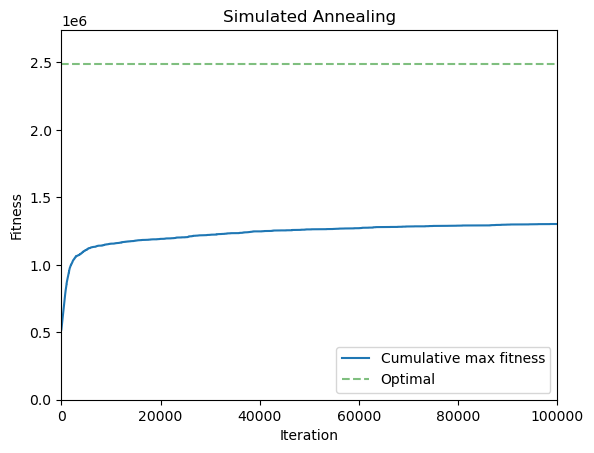

Experiment: Simulated Annealing
Best Fitness: 1302516
 Knapsack 0: items [933, 1021, 1074, 1546, 1584, 1648, 1656, 1844, 2071, 2345, 2347, 2480, 2579, 2898, 3169, 3189, 3444, 3447, 3522, 3555, 3736, 3773, 3777, 4578, 4710, 4926]
 Knapsack 1: items [22, 257, 287, 489, 850, 1153, 1262, 1360, 1466, 1525, 1653, 2033, 2091, 2314, 2547, 2654, 2906, 3500, 3541, 4367, 4369, 4447, 4603, 4822]
 Knapsack 2: items [173, 246, 845, 846, 964, 1047, 1331, 2139, 2151, 2203, 2889, 2948, 3037, 3052, 3071, 3080, 3199, 3349, 3852, 3953, 4296, 4535, 4621]
 Knapsack 3: items [35, 81, 461, 506, 640, 1293, 1314, 1672, 1674, 1832, 2067, 2192, 2251, 2407, 2605, 2833, 3117, 3227, 3827, 3863, 3886, 4098, 4432, 4491, 4792]
 Knapsack 4: items [433, 587, 708, 798, 891, 1173, 1414, 1661, 1693, 1796, 1951, 1993, 2083, 2135, 2188, 2207, 2491, 2726, 2834, 2921, 3001, 3115, 3487, 3815, 4191, 4382, 4650, 4798]
 Knapsack 5: items [43, 441, 532, 563, 611, 842, 899, 1085, 1248, 1372, 1567, 2140, 2184, 2185, 2310, 2780, 2842, 

In [23]:
results = sa_solver(solution, max_iter=100000, restarted=True)
results.plot_fitness()
print(results)

100%|██████████| 4/4 [04:43<00:00, 70.79s/it]


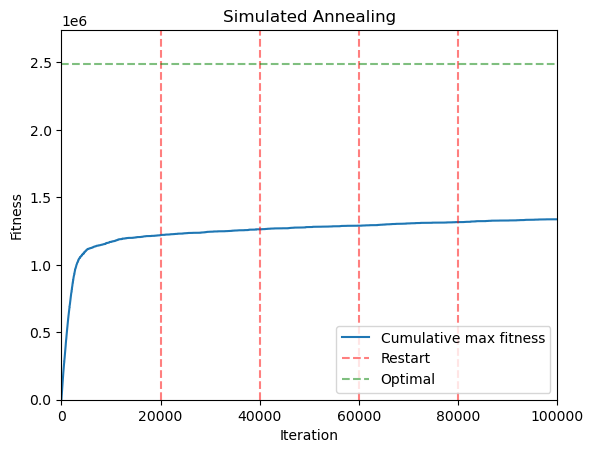

Experiment: Simulated Annealing
Best Fitness: 1337524
 Knapsack 0: items [1, 273, 278, 286, 355, 384, 792, 996, 1016, 1092, 1505, 1649, 1937, 2022, 2042, 2082, 2244, 2450, 2489, 2606, 2928, 3017, 3253, 3967, 4230, 4457, 4507]
 Knapsack 1: items [54, 197, 411, 1036, 1062, 1168, 1306, 1308, 1398, 1766, 1818, 1932, 2266, 2413, 2843, 3127, 3396, 3570, 3696, 3954, 4205, 4315, 4323, 4912]
 Knapsack 2: items [483, 667, 780, 1075, 1180, 1546, 1629, 2058, 2300, 2359, 2546, 2776, 2967, 3032, 3201, 3256, 3331, 3353, 3597, 3920, 4068, 4089, 4432, 4686, 4895]
 Knapsack 3: items [440, 659, 685, 873, 1045, 1247, 1263, 1342, 1777, 1837, 1879, 2361, 2551, 2667, 2847, 2959, 3102, 3180, 3416, 3762, 3886, 3936, 4149, 4408, 4411, 4434, 4914, 4982]
 Knapsack 4: items [61, 291, 466, 542, 1282, 1480, 1562, 1635, 2094, 2305, 2406, 2555, 2609, 2954, 2983, 3299, 3460, 3521, 3692, 3734, 3839, 3849, 3862, 4211, 4297, 4464, 4541, 4608]
 Knapsack 5: items [454, 616, 711, 1142, 1284, 1461, 1527, 2032, 2120, 2178, 257

In [24]:
solution = np.ones(NUM_ITEMS, dtype=int) * -1
rounds = 5
schedule = np.ones(rounds) * 100
results = sa_solver(solution, max_iter=20000, initial_temp=schedule[0], restarted=True)
for i in tqdm(range(1, rounds)):
    new_results = sa_solver(results.best_solution, max_iter=20000, initial_temp=schedule[i], restarted=True)
    results.join(new_results)
results.plot_fitness()
print(results)